# `tf.data` API

* References
  * [`tf.data.Dataset` API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
  * [Importing data](https://www.tensorflow.org/guide/datasets) (Guideline Documents)

`tf.data` API has two new abstractions
* `tf.data.Dataset` represents a sequence of elements, in which each element contains one or more Tensor objects. For example, in an image pipeline, the image data and a label
  * Creating a source (e.g. Dataset.from_tensor_slices()) constructs a dataset from one or more `tf.Tensor` objects.
    * `tf.data.Dataset.from_tensors()`
    * `tf.data.Dataset.from_tensor_slices()`
    * `tf.data.TFRecordDataset`:  TFRecord format을 읽을 때
  * Applying a transformation (e.g. Dataset.batch()) constructs a dataset from one or more `tf.data.Dataset` objects.
* `tf.data.Iterator` provides the main way to extract elements from a dataset. The operation returned by `Iterator.get_next()` yields the next element of a `Dataset` when executed, and typically acts as the interface between input pipeline code and your model.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

### Loading MNIST dataset from `tf.keras`

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

### Shot the MNIST

label = 3


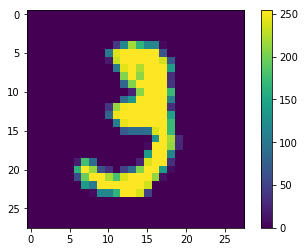

In [3]:
index = 10
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [4]:
# set N=50 for small dataset loading
N = 50
train_data = train_data[:N]
train_labels = train_labels[:N]
train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data[:N]
test_labels = test_labels[:N]
test_data = test_data / 255.
test_labels = np.asarray(test_labels, dtype=np.int32)

## Input pipeline

1. You must define a source. `tf.data.Dataset`.
  * To construct a Dataset from some tensors in memory, you can use `tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`.
  * Other methods
    * `tf.data.TextLineDataset(filenames)`
    * `tf.data.FixedLengthRecordDataset(filenames)`
    * `tf.data.TFRecordDataset(filenames)`
2. Transformation
  * `Dataset.map()`: to apply a function to each element
  * `Dataset.batch()`
  * `Dataset.shuffle()`
3. `Iterator`
  * `Iterator.initializer`: which enables you to (re)initialize the iterator's state
  * `Iterator.get_next()`

### 1. Store data in `tf.data.Dataset`

* `tf.data.Dataset.from_tensor_slices((features, labels))`
* `tf.data.Dataset.from_generator(gen, output_types, output_shapes)`

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
print(train_dataset)
print(train_dataset.output_shapes)
print(train_dataset.output_types)

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float64, tf.int32)>
(TensorShape([Dimension(28), Dimension(28)]), TensorShape([]))
(tf.float64, tf.int32)


### 2. Transformaion

* `apply(transformation_func)`
* `batch(batch_size)`
* `concatenate(dataset)`
* `flat_map(map_func)`
* `repeat(count=None)`
  * count=max_epochs
* `shuffle(buffer_size, seed=None, reshuffle_each_iteration=None)`

In [6]:
batch_size = 16

train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count=2)
train_dataset = train_dataset.batch(batch_size = batch_size)

### 3. Iterator

#### 3.1 `make_one_shot_iterator()`

* Creates an Iterator for enumerating the elements of this dataset.
  * Note: The returned iterator will be initialized automatically. A "one-shot" iterator does not currently support re-initialization.

###### Common pattern
```python
while True:
  try:
    sess.run(result)
  except tf.errors.OutOfRangeError:
    break
```

In [7]:
train_iterator = train_dataset.make_one_shot_iterator()

x, y = train_iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

#### `for`문으로 epoch control 시 유의점

* 사실상 `dataset.repeat(count=2)` 함수로 max_epochs 조절함
* `for`문으로 epoch을 조절하고 싶으면 `dataset.repeat()` 쓰지 않으면 됨
  * `while`문을 다 돌면 count 만큼의 epochs이 끝남
* `for`문으로 control 하고 싶으면 `for`문 시작할 때마다 `iterator.initializer`를 해야 함
  * 다음 예제 참고

In [8]:
with tf.Session(config=sess_config) as sess:
  #sess.run(iterator.initializer) 할 필요 없음
  step = 0
  while True:
    try:
      x_, y_ = sess.run([x, y])

      print("step: {}  labels: {}".format(step, y_))
      step += 1

    except tf.errors.OutOfRangeError:
      print("End of dataset")  # ==> "End of dataset"
      break

step: 0  labels: [9 5 3 1 8 0 7 1 4 9 6 3 5 1 0 6]
step: 1  labels: [3 9 6 6 9 0 1 9 2 2 3 1 3 8 3 7]
step: 2  labels: [8 9 4 3 8 1 0 9 4 4 1 5 2 7 6 5]
step: 3  labels: [7 2 1 9 9 1 7 6 9 1 4 4 4 1 4 1]
step: 4  labels: [2 7 8 6 2 3 9 7 6 8 9 1 5 0 0 5]
step: 5  labels: [8 6 5 3 9 3 9 8 3 3 3 6 2 1 5 7]
step: 6  labels: [2 0 0 3]
End of dataset


In [9]:
with tf.Session(config=sess_config) as sess:
  #sess.run(iterator.initializer) 할 필요 없음
  step = 0
  max_epochs = 3
  for epoch in range(max_epochs):
    while True:
      try:
        x_, y_ = sess.run([x, y])

        print("step: {}  labels: {}".format(step, y_))
        step += 1

      except tf.errors.OutOfRangeError:
        print("End of dataset")  # ==> "End of dataset"
        break

step: 0  labels: [2 6 8 7 1 3 1 1 1 5 2 9 7 1 6 7]
step: 1  labels: [6 4 3 3 3 8 1 9 3 5 9 5 6 7 3 4]
step: 2  labels: [4 2 0 9 0 9 0 8 9 2 9 6 8 0 1 3]
step: 3  labels: [4 5 0 1 7 4 7 2 3 3 2 8 1 0 1 5]
step: 4  labels: [9 6 3 3 6 5 7 9 6 9 5 9 2 8 3 0]
step: 5  labels: [4 4 5 2 3 6 8 1 1 3 0 9 7 1 4 6]
step: 6  labels: [1 9 9 8]
End of dataset
End of dataset
End of dataset


#### 3.2 `make_initializable_iterator()`

* Creates an Iterator for enumerating the elements of this dataset.
* Should `run` the `iterator.initializer`.

사용법
```python
dataset = ...
iterator = dataset.make_initializable_iterator()
# ...
sess.run(iterator.initializer)
```

In [10]:
train_iterator = train_dataset.make_initializable_iterator()

x, y = train_iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

#### `for`문으로 epoch control 시 유의점

* `iterator.initializer`를 통해서 매 `for`문 마다 dataset을 initial 해야함
* `N / batch_size`가 나누어 떨어지지 않으면 맨 마지막 배치는 `N % batch_size` 만큼의 데이터만 불러옴

In [11]:
with tf.Session(config=sess_config) as sess:
  sess.run(train_iterator.initializer)
  step = 0
  while True:
    try:
      x_, y_ = sess.run([x, y])

      print("step: {}  labels: {}".format(step, y_))
      step += 1

    except tf.errors.OutOfRangeError:
      print("End of dataset")  # ==> "End of dataset"
      break

step: 0  labels: [0 3 8 6 3 8 9 1 0 4 8 0 1 9 2 1]
step: 1  labels: [0 5 4 7 8 9 7 5 1 4 7 6 2 1 3 3]
step: 2  labels: [3 6 2 9 6 5 3 7 5 6 1 3 4 1 9 9]
step: 3  labels: [9 2 4 5 9 8 1 0 3 2 7 1 0 4 3 9]
step: 4  labels: [3 2 1 6 5 4 9 6 8 7 8 0 0 5 5 3]
step: 5  labels: [2 2 1 4 7 6 3 1 6 9 9 1 6 9 1 9]
step: 6  labels: [8 3 7 3]
End of dataset


In [12]:
with tf.Session(config=sess_config) as sess:
  step = 0
  max_epochs = 3
  for epoch in range(max_epochs):
    sess.run(train_iterator.initializer)
    while True:
      try:
        x_, y_ = sess.run([x, y])

        print("step: {}  labels: {}".format(step, y_))
        step += 1

      except tf.errors.OutOfRangeError:
        print("End of dataset")  # ==> "End of dataset"
        break

step: 0  labels: [6 2 0 3 1 0 9 5 5 2 1 1 4 6 7 2]
step: 1  labels: [5 4 3 3 8 8 2 8 5 9 9 9 6 4 7 0]
step: 2  labels: [9 9 1 9 4 1 0 6 7 7 3 8 1 6 3 3]
step: 3  labels: [3 1 0 7 9 1 8 1 3 4 1 9 6 6 2 4]
step: 4  labels: [1 3 8 3 8 2 7 2 7 4 3 2 9 3 5 8]
step: 5  labels: [6 6 5 7 9 4 9 6 0 5 1 9 0 9 3 1]
step: 6  labels: [0 1 3 5]
End of dataset
step: 7  labels: [0 1 7 7 9 9 5 6 2 9 3 9 3 2 8 7]
step: 8  labels: [3 6 3 1 2 7 4 0 8 0 6 6 2 1 1 5]
step: 9  labels: [8 3 8 5 4 4 9 4 1 9 5 1 3 6 3 1]
step: 10  labels: [9 0 2 9 4 2 5 6 7 3 3 4 1 1 6 4]
step: 11  labels: [7 6 1 0 9 5 8 3 1 9 3 8 1 9 6 1]
step: 12  labels: [2 3 2 0 5 8 6 7 4 1 0 9 5 8 3 7]
step: 13  labels: [0 3 9 9]
End of dataset
step: 14  labels: [5 1 9 4 9 2 5 7 4 7 1 3 0 8 0 3]
step: 15  labels: [3 1 3 0 6 8 4 8 2 7 5 4 3 6 7 2]
step: 16  labels: [9 9 3 2 1 5 8 6 6 9 1 3 0 6 9 1]
step: 17  labels: [1 9 4 6 5 9 9 6 0 7 5 9 1 6 7 2]
step: 18  labels: [8 9 0 3 6 6 1 5 8 8 2 4 3 2 1 1]
step: 19  labels: [8 3 1 4 3 0 9 0 7 4 2

## [From TensorFlow official site](https://www.tensorflow.org/programmers_guide/datasets)

* 밑에 예제들은 TF 홈페이지에서 가져옴

### Data structure

In [13]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random_uniform([4, 10]))
print(dataset1.output_types)  # ==> "tf.float32"
print(dataset1.output_shapes)  # ==> "(10,)"

dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random_uniform([4]),
    tf.random_uniform([4, 100], maxval=100, dtype=tf.int32)))
print(dataset2.output_types)  # ==> "(tf.float32, tf.int32)"
print(dataset2.output_shapes)  # ==> "((), (100,))"

dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
print(dataset3.output_types)  # ==> (tf.float32, (tf.float32, tf.int32))
print(dataset3.output_shapes)  # ==> "(10, ((), (100,)))"

<dtype: 'float32'>
(10,)
(tf.float32, tf.int32)
(TensorShape([]), TensorShape([Dimension(100)]))
(tf.float32, (tf.float32, tf.int32))
(TensorShape([Dimension(10)]), (TensorShape([]), TensorShape([Dimension(100)])))


### Naming

In [14]:
dataset = tf.data.Dataset.from_tensor_slices(
   {"a": tf.random_uniform([4]),
    "b": tf.random_uniform([4, 100], maxval=100, dtype=tf.int32)})
print(dataset.output_types)  # ==> "{'a': tf.float32, 'b': tf.int32}"
print(dataset.output_shapes)  # ==> "{'a': (), 'b': (100,)}"

{'a': tf.float32, 'b': tf.int32}
{'a': TensorShape([]), 'b': TensorShape([Dimension(100)])}


## Creating an iterator

In [15]:
dataset = tf.data.Dataset.range(100)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

with tf.Session() as sess:
  for i in range(10):
    value = sess.run(next_element)
    print(value)

0
1
2
3
4
5
6
7
8
9


In [16]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

with tf.Session() as sess:
  # Initialize an iterator over a dataset with 10 elements.
  sess.run(iterator.initializer, feed_dict={max_value: 10})
  for i in range(10):
    value = sess.run(next_element)
    print(value)

  # Initialize the same iterator over a dataset with 100 elements.
  sess.run(iterator.initializer, feed_dict={max_value: 100})
  for i in range(100):
    value = sess.run(next_element)
    print(value)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
